# <strong><font color="450693">TelecomX: Prevendo a evasão dos clientes</font></strong>

---


**Problema de negócio:**

A empresa enfrenta um alto índice de cancelamentos(Churn) e através da análise dos dados fornecido, foi identificado as categorias com maiores índices de Churn.
Entendemos o passado e o presente, agora vamos entender o futuro!

**Desafio:**

Prever a evasão futura dos clientes.
Para ajudar nesse desafio, alguns questionamentos devem ser respondidos:


* Quem são os clientes com maior risco de evasão?
* Quais variáveis influenciam mais a evasão?
* Qual perfil de cliente precisa de um contato mais ativo?

---



**Responder essas perguntas e criar modelos preditivos para novos clientes é crucial para diminuir o índice de evasão (churn).**


Padrão de cores:

```
roxo: 450693
roxo_claro: 8C00FF
rosa: 9E1C60
amarelo: FF9D00
```





---
# <font color="450693">**Importando Bibliotecas**</font>

---




In [70]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


In [71]:
import warnings
warnings.filterwarnings("ignore")

# <font color="450693">**1 - Obtenção do arquivo**</font>

---

In [72]:
clientes = pd.read_csv('/content/dados.csv')

####<font color="8C00FF"> Explorando os dados</font>

In [73]:
clientes.describe(include='O')
#clientes.describe()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Total
count,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267,7267
unique,7267,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531
top,9995-HOTOH,No,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,20.2
freq,1,5398,3675,6085,3749,5086,6560,3495,3198,3608,3182,3195,3582,2896,2870,4005,4311,2445,11


In [74]:
clientes.drop('customerID', axis=1, inplace=True)

### **<font color="8C00FF">1.1. Converter as colunas 'tenure', 'Charges.Monthly', 'Charges.Total' para numéricas</font>**

In [75]:
clientes['Charges.Total'] = clientes['Charges.Total'].fillna(0)

In [76]:
# Garantindo conversão correta para numérico
clientes['tenure'] = pd.to_numeric(clientes['tenure'], errors='coerce')
clientes['Charges.Monthly'] = pd.to_numeric(clientes['Charges.Monthly'], errors='coerce')
clientes['Charges.Total'] = pd.to_numeric(clientes['Charges.Total'], errors='coerce').fillna(0)

clientes[['tenure', 'Charges.Monthly','Charges.Total']].dtypes

,0
tenure,int64
Charges.Monthly,float64
Charges.Total,float64


### **<font color="8C00FF">1.2. Aplicar One-Hot Encoding nas variaveis multicategóricas</font>**

In [77]:
if 'PaymentMethod' in clientes.columns:
    clientes = pd.get_dummies(
        clientes,
        columns=['PaymentMethod'],
        prefix='Payment',
        drop_first=True
    )

In [78]:
if 'Contract' in clientes.columns:
    clientes = pd.get_dummies(
        clientes,
        columns=['Contract'],
        prefix='Contract',
        drop_first=False
    )

In [79]:
if 'MultipleLines' in clientes.columns:
    clientes = pd.get_dummies(
        clientes,
        columns=['MultipleLines'],
        prefix='Multilines',
        drop_first=False
)

In [80]:
if 'InternetService' in clientes.columns:
    clientes = pd.get_dummies(
        clientes,
        columns=['InternetService'],
        prefix='Internet',
        drop_first=False
)

In [81]:
# Para conferencia:
# clientes.filter(like='payment_').head()
# clientes.filter(like='Contract_').head()
# clientes.filter(like='Multilines_').head()
# clientes.filter(like='Internet_').head()

### **<font color="8C00FF">1.3. Identificar variáveis categóricas binárias</font>**

In [82]:
clientes.rename(columns={'gender': 'Sexo_masculino'}, inplace=True)

In [83]:
categoricas = clientes.select_dtypes(include='object').columns

# Verificando quais são binárias
binarias = [col for col in categoricas
    if clientes[col].nunique() == 2
]

binarias

['Churn',
 'Sexo_masculino',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling']

###<font color="8C00FF">**1.4. Mapear valores para 1 (Sim) e 2 (Não)**</font>

####<font color = "8C00FF">Normalize strings</font>

In [84]:
for col in clientes.columns:
    if clientes[col].dtype == 'object':
        clientes[col] = clientes[col].str.strip()

####<font color = "8C00FF">Mapear **sexo_masculino** (Male / Female)</font>

In [85]:
clientes['Sexo_masculino'] = clientes['Sexo_masculino'].map({
    'Male': 1,
    'Female': 0
})

####<font color = "8C00FF">Mapear colunas **'Churn','SeniorCitizen','Partner','Dependents','PhoneService','PaperlessBilling'**(Yes/No)</font>

In [86]:
clientes.head(2)

,Churn,Sexo_masculino,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,...,Payment_Mailed check,Contract_Month-to-month,Contract_One year,Contract_Two year,Multilines_No,Multilines_No phone service,Multilines_Yes,Internet_DSL,Internet_Fiber optic,Internet_No
0,No,0,No,Yes,Yes,9,Yes,No,Yes,No,...,True,False,True,False,True,False,False,True,False,False
1,No,1,No,No,No,9,Yes,No,No,No,...,True,True,False,False,False,False,True,True,False,False


In [87]:
colunas_yes_no = [
    'Churn',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'PhoneService',
    'PaperlessBilling'
]

mapa_yes_no = {
    'Yes': 1,
    'No': 0
}

for col in colunas_yes_no:
    clientes[col] = clientes[col].map(mapa_yes_no)

####<font color = "8C00FF">Validação obrigatória

In [88]:
clientes[colunas_yes_no + ['Sexo_masculino']].isna().sum()

,0
Churn,0
SeniorCitizen,0
Partner,0
Dependents,0
PhoneService,0
PaperlessBilling,0
Sexo_masculino,0


In [89]:
clientes[colunas_yes_no + ['Sexo_masculino']].head()


,Churn,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Sexo_masculino
0,0,0,1,1,1,1,0
1,0,0,0,0,1,0,1
2,1,0,0,0,1,1,1
3,1,1,1,0,1,1,1
4,1,1,1,0,1,1,0


####<font color = "8C00FF">Mapear **colunas de serviços**</font>

In [90]:
colunas_servicos = [
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'
]

In [91]:
mapa_servicos = {
    'Yes': 1,
    'No': 0,
    'No internet service': 0
}

In [92]:
for col in colunas_servicos:
    clientes[col] = clientes[col].map(mapa_servicos)

####<font color = "8C00FF">Validação obrigatória

In [93]:
clientes[colunas_servicos].isna().sum()

,0
OnlineSecurity,0
OnlineBackup,0
DeviceProtection,0
TechSupport,0
StreamingTV,0
StreamingMovies,0


In [94]:
clientes[colunas_servicos].head()

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,0,1,0,1,1,0
1,0,0,0,0,0,1
2,0,0,1,0,0,0
3,0,1,1,0,1,1
4,0,0,0,1,1,0


In [95]:
clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Churn                            7267 non-null   int64  
 1   Sexo_masculino                   7267 non-null   int64  
 2   SeniorCitizen                    7267 non-null   int64  
 3   Partner                          7267 non-null   int64  
 4   Dependents                       7267 non-null   int64  
 5   tenure                           7267 non-null   int64  
 6   PhoneService                     7267 non-null   int64  
 7   OnlineSecurity                   7267 non-null   int64  
 8   OnlineBackup                     7267 non-null   int64  
 9   DeviceProtection                 7267 non-null   int64  
 10  TechSupport                      7267 non-null   int64  
 11  StreamingTV                      7267 non-null   int64  
 12  StreamingMovies     

### <font color="8C00FF">**1.5 - Identificando e transformando em variáveis Numéricas**</font>

####<font color = "8C00FF">Converter as colunas com bool para int64</font>

In [96]:
colunas_bool = clientes.select_dtypes(include='bool').columns

clientes[colunas_bool] = clientes[colunas_bool].astype(int)

####<font color = "8C00FF">Agrupando as Variaveis Numericas</font>

In [97]:
variaveis_numericas = clientes.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [98]:
# Removendo a variável target das numéricas
variaveis_numericas.remove('Churn')

In [99]:
variaveis_numericas

['Sexo_masculino',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'Charges.Monthly',
 'Charges.Total',
 'Payment_Credit card (automatic)',
 'Payment_Electronic check',
 'Payment_Mailed check',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'Multilines_No',
 'Multilines_No phone service',
 'Multilines_Yes',
 'Internet_DSL',
 'Internet_Fiber optic',
 'Internet_No']

In [100]:
clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Churn                            7267 non-null   int64  
 1   Sexo_masculino                   7267 non-null   int64  
 2   SeniorCitizen                    7267 non-null   int64  
 3   Partner                          7267 non-null   int64  
 4   Dependents                       7267 non-null   int64  
 5   tenure                           7267 non-null   int64  
 6   PhoneService                     7267 non-null   int64  
 7   OnlineSecurity                   7267 non-null   int64  
 8   OnlineBackup                     7267 non-null   int64  
 9   DeviceProtection                 7267 non-null   int64  
 10  TechSupport                      7267 non-null   int64  
 11  StreamingTV                      7267 non-null   int64  
 12  StreamingMovies     

####<font color="8C00FF"> Salvando dados tratados para usar em outro notebook</font>

In [101]:
clientes.to_csv("dados_tratados.csv", index=False)

# <font color="450693">**2. Variáveis Destacadas quanto ao impacta no Churn**

---

</font>

**1. Perfil do Cliente**
* Gender
* SeniorCitizen
* Partner
* Dependents
---
**2. Relacionamento com a empresa**
* tenure
* Contract
* PaperlessBilling
* PaymentMethod
---
**3. Serviços Contratados**
* PhoneService
* MultipleLines
* InternetService
* OnlineSecurity
* OnlineBackup
* DeviceProtection
* TechSupport
* StreamingTV
* StreamingMovies
---
**4. Cobrança**
* Charges.Monthly
* Charges.Total

#<font color="450693">**3. Estabelecendo as variaveis que serão usadas**:</font>

---



### <font color="8C00FF">**3.1. Comparar Churn × variáveis de Perfil do Cliente**</font>

In [102]:
variaveis_perfil = ['Sexo_masculino', 'SeniorCitizen', 'Partner', 'Dependents']

impacto_perfil = {}

for col in variaveis_perfil:
    churn_1 = clientes[clientes[col] == 1]['Churn'].mean()
    churn_0 = clientes[clientes[col] == 0]['Churn'].mean()
    impacto_perfil[col] = abs(churn_1 - churn_0)

impacto_perfil_ordenado = dict(
    sorted(impacto_perfil.items(), key=lambda x: x[1], reverse=True)
)


print("=" * 70)
print("Variáveis com maior impacto no Churn:\n")

for var, diff in impacto_perfil_ordenado.items():
    print(f"- {var}: diferença de churn = {diff:.2%}")

print("=" * 70)
print("""Conclusão:
As variáveis de perfil pouco impactam no Churn. Entre elas observa-se\nque SeniorCitizen é mais significativa quanto a evasão (Churn),\ndevendo ser usada como variáveis explicativas no Machine Learning.""")
print("=" * 70)

Variáveis com maior impacto no Churn:

- SeniorCitizen: diferença de churn = 17.38%
- Dependents: diferença de churn = 15.39%
- Partner: diferença de churn = 12.99%
- Sexo_masculino: diferença de churn = 0.84%
Conclusão:
As variáveis de perfil pouco impactam no Churn. Entre elas observa-se
que SeniorCitizen é mais significativa quanto a evasão (Churn),
devendo ser usada como variáveis explicativas no Machine Learning.


###<font color="8C00FF">**3.2. Comparar Churn × variáveis de Relacionamento com a empresa x variáveis de cobrança.**</font>

In [103]:
# Variáveis binárias (0/1)
variaveis_binarias_relacionamento = [
    'Contract_Month-to-month',
    'Contract_One year',
    'Contract_Two year',
    'PaperlessBilling',
    'Payment_Credit card (automatic)',
    'Payment_Electronic check',
    'Payment_Mailed check'
]

# Variáveis contínuas
variaveis_continuas = [
    'tenure',
    'Charges.Monthly',
    'Charges.Total'
]

def impacto_binaria(df, col, target='Churn'):
    churn_1 = df[df[col] == 1][target].mean()
    churn_0 = df[df[col] == 0][target].mean()
    return abs(churn_1 - churn_0)

def impacto_continua(df, col, target='Churn'):
    media = df.groupby(target)[col].mean()
    return abs(media[1] - media[0])

impactos = {}

# Binárias
for col in variaveis_binarias_relacionamento:
    impactos[col] = impacto_binaria(clientes, col)

# Contínuas
for col in variaveis_continuas:
    impactos[col] = impacto_continua(clientes, col)

impactos_ordenados = dict(
    sorted(impactos.items(), key=lambda x: x[1], reverse=True)
)

print("=" * 70)
print("Impacto das variáveis de relacionamento e cobrança no Churn\n")

for var, valor in impactos_ordenados.items():
    if var in variaveis_continuas:
        unidade = "meses" if var == 'tenure' else "unidades monetárias"
        print(f"- {var}: diferença média = {valor:.2f} {unidade}")
    else:
        print(f"- {var}: diferença na taxa de churn = {valor:.2%}")

print("=" * 70)
print("Conclusão:")
# Assign diff_tenure before using it
diff_tenure = impactos_ordenados['tenure']
print(
    "Clientes que evadiram possuem, em média, "f"{diff_tenure:.2f} meses a menos de \nrelacionamento com a empresa, indicando que menor tempo de contrato"
    "\nestá fortemente associado ao churn."
    "\n"
    "\nImpactam mais significativamente no Churn:\nContract_Month-to-month e Payment_Eletronic check."
)

print("=" * 70)

Impacto das variáveis de relacionamento e cobrança no Churn

- Charges.Total: diferença média = 1003.47 unidades monetárias
- tenure: diferença média = 19.34 meses
- Charges.Monthly: diferença média = 13.09 unidades monetárias
- Contract_Month-to-month: diferença na taxa de churn = 34.76%
- Contract_Two year: diferença na taxa de churn = 30.21%
- Payment_Electronic check: diferença na taxa de churn = 27.25%
- Contract_One year: diferença na taxa de churn = 18.70%
- PaperlessBilling: diferença na taxa de churn = 16.61%
- Payment_Credit card (automatic): diferença na taxa de churn = 13.93%
- Payment_Mailed check: diferença na taxa de churn = 9.37%
Conclusão:
Clientes que evadiram possuem, em média, 19.34 meses a menos de 
relacionamento com a empresa, indicando que menor tempo de contrato
está fortemente associado ao churn.

Impactam mais significativamente no Churn:
Contract_Month-to-month e Payment_Eletronic check.


###<font color="8C00FF">**3.3. Comparar Churn × variáveis de Serviços Contratados**</font>

In [104]:
variaveis_servicos = [
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'
]

def impacto_binaria(df, col, target='Churn'):
    churn_1 = df[df[col] == 1][target].mean()
    churn_0 = df[df[col] == 0][target].mean()
    return abs(churn_1 - churn_0)

impactos_servicos = {}

for col in variaveis_servicos:
    impactos_servicos[col] = impacto_binaria(clientes, col)

impactos_servicos = dict(
    sorted(impactos_servicos.items(), key=lambda x: x[1], reverse=True)
)

print("=" * 70)
print("Impacto dos Serviços contratados no Churn\n")

for var, impacto in impactos_servicos.items():
    print(f"- {var}: diferença na taxa de churn = {impacto:.2%}")

print("=" * 70)
print("Conclusão:")
print(
    "Os serviços contratados pouco influem no Churn, entretanto, entre eles\n'OnlineSecurity' e 'TechSupport' são os que mais impactam."
)
print("=" * 70)


Impacto dos Serviços contratados no Churn

- OnlineSecurity: diferença na taxa de churn = 16.14%
- TechSupport: diferença na taxa de churn = 15.46%
- OnlineBackup: diferença na taxa de churn = 7.37%
- DeviceProtection: diferença na taxa de churn = 5.84%
- StreamingTV: diferença na taxa de churn = 5.61%
- StreamingMovies: diferença na taxa de churn = 5.44%
Conclusão:
Os serviços contratados pouco influem no Churn, entretanto, entre eles
'OnlineSecurity' e 'TechSupport' são os que mais impactam.


###<font color="8C00FF">**3.4. Variáves evasivas:**</font>

In [167]:
def variaveis_evasivas():
    dados = {
        'SeniorCitizen': impacto_perfil_ordenado['SeniorCitizen'],
        'tenure': impactos_ordenados['tenure'],
        'Contract_Month-to-month': impactos_ordenados['Contract_Month-to-month'],
        'Payment_Electronic check': impactos_ordenados['Payment_Electronic check'],
        'PaperlessBilling': impactos_ordenados['PaperlessBilling'],
        'OnlineSecurity': impactos_servicos['OnlineSecurity'],
        'TechSupport': impactos_servicos['TechSupport']
    }

    df_impacto = (
        pd.DataFrame(list(dados.items()), columns=['Variavel', 'Impacto'])
        .sort_values('Impacto', ascending=True)
    )

    fig, ax = plt.subplots(figsize=(9, 5))

    ax.barh(
        df_impacto['Variavel'],
        df_impacto['Impacto'],
        color='#FF9D00'
    )

    ax.set_title(
        'Variáveis Mais Evasivas no Churn de Clientes',
        fontsize=15,
        weight='bold',
        pad=15
    )

    ax.set_xlabel('Impacto no Churn', fontsize=11)
    ax.set_ylabel('Variável', fontsize=11)

    ax.grid(axis='x', linestyle='--', alpha=0.4)

    return fig

# <font color="450693">**4. Proporção de clientes com Churn x clientes ativos**</font>

---



In [105]:
clientes['Churn'].value_counts(normalize=True)

,proportion
Churn,
0,0.74281
1,0.25719


In [106]:
clientes['Churn'].value_counts()

,count
Churn,
0,5398
1,1869


In [107]:
print("Conclusão:\n 1869 contratos tiveram Churn, representando 25% dos contratos.")

Conclusão:
 1869 contratos tiveram Churn, representando 25% dos contratos.


# <font color="450693">**5. Modelos**</font>
---
<font color="450693">Modelos que exigem normalização

*   <font color="450693">Regressão Logística (baseline interpretável)
*   <font color="450693">KNN
* <font color="450693">SVM
* <font color="450693">Redes Neurais
---
<font color="450693">Modelos que sem normalização

* <font color="450693">Árvore de Decisão
* <font color="450693">Random Forest(sem linearidade)

###<font color="8C00FF">**5.1. Correlação**</font>

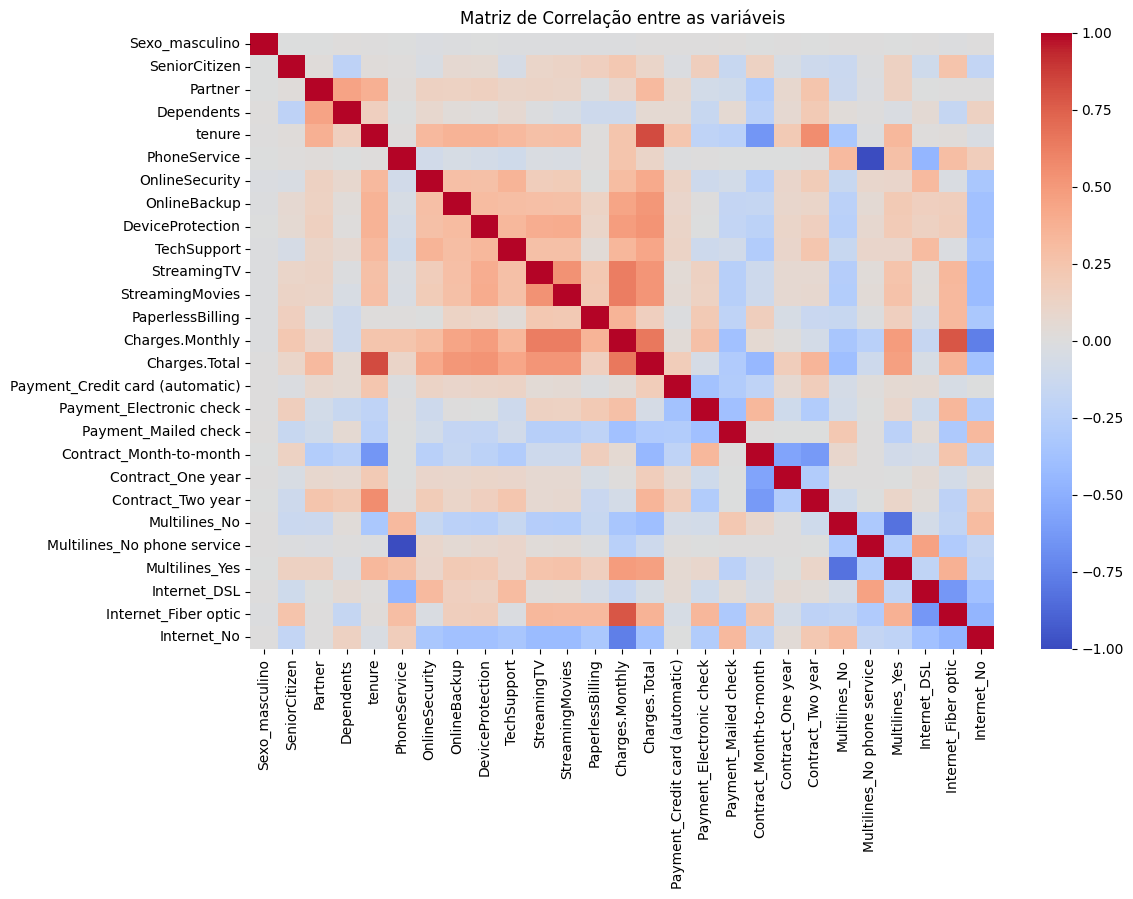

In [108]:
plt.figure(figsize=(12,8))
sns.heatmap(
    clientes.drop('Churn', axis=1).corr(), # Directly using 'clientes' and dropping 'Churn' for feature correlations
    cmap='coolwarm',
    center=0
)
plt.title('Matriz de Correlação entre as variáveis')
plt.show()

In [109]:
correlacao_churn = (
    clientes
    .corr()['Churn']
    .sort_values(ascending=False)
)

print("=" * 70)

correlacao_churn = correlacao_churn.drop('Churn')

print("Variáveis mais correlacionadas com Churn")
print("=" * 70)
print("🔴 Correlação Positiva (maior chance de Churn):\n")
print(correlacao_churn.head(10))
print("=" * 70)
print("🟢 Correlação Negativa (menor chance de Churn):")
print(correlacao_churn.tail(10))

print("=" * 70)


Variáveis mais correlacionadas com Churn
🔴 Correlação Positiva (maior chance de Churn):

Contract_Month-to-month     0.395584
Internet_Fiber optic        0.300949
Payment_Electronic check    0.294626
Charges.Monthly             0.189866
PaperlessBilling            0.186666
SeniorCitizen               0.146733
StreamingTV                 0.062430
StreamingMovies             0.060586
Multilines_Yes              0.039343
PhoneService                0.012571
Name: Churn, dtype: float64
🟢 Correlação Negativa (menor chance de Churn):
Payment_Credit card (automatic)   -0.131085
Partner                           -0.148546
TechSupport                       -0.160440
Dependents                        -0.161384
OnlineSecurity                    -0.166828
Contract_One year                 -0.173958
Charges.Total                     -0.193345
Internet_No                       -0.224051
Contract_Two year                 -0.295138
tenure                            -0.344079
Name: Churn, dtype: float6

In [110]:
print(
    "Analisando a matriz de correlação, as variáveis com mais chance\n"
    "de Churn são os contratos Month-to-month e electronic check.\n\n"
    "Por outro lado, variáveis como contratos de longo prazo e serviços ,\n"
    "de suporte e segurança apresentam menor risco de evasão de clientes."
)

Analisando a matriz de correlação, as variáveis com mais chance
de Churn são os contratos Month-to-month e electronic check.

Por outro lado, variáveis como contratos de longo prazo e serviços ,
de suporte e segurança apresentam menor risco de evasão de clientes.


###<font color="8C00FF">**5.2. Correlação por variavel com mais impacto no Churn:**</font>

####<font color="8C00FF">Tenure × Churn

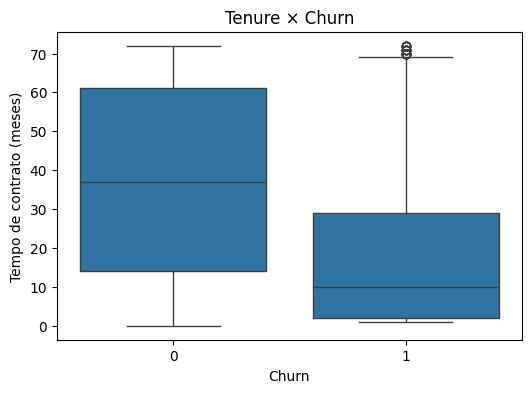

In [111]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='tenure', data=clientes)
plt.title('Tenure × Churn')
plt.xlabel('Churn')
plt.ylabel('Tempo de contrato (meses)')
plt.show()

####<font color="8C00FF">Contract_Month-to-month × Churn

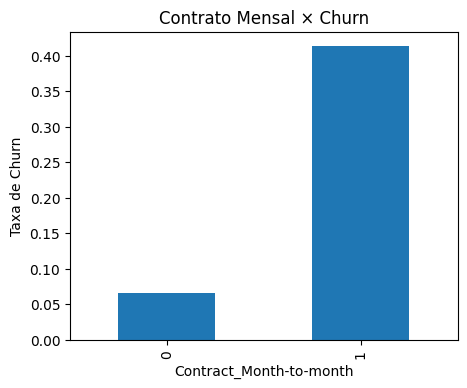

In [112]:
clientes.groupby('Contract_Month-to-month')['Churn'].mean().plot(
    kind='bar',
    figsize=(5,4),
    title='Contrato Mensal × Churn'
)
plt.ylabel('Taxa de Churn')
plt.show()

####<font color="8C00FF">Payment_Eletronic check × Churn

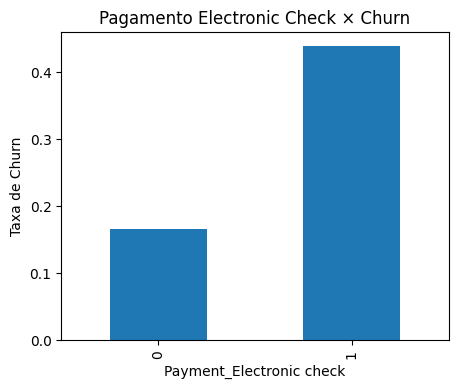

In [113]:
clientes.groupby('Payment_Electronic check')['Churn'].mean().plot(
    kind='bar',
    figsize=(5,4),
    title='Pagamento Electronic Check × Churn'
)
plt.ylabel('Taxa de Churn')
plt.show()

####<font color="8C00FF">OnlineSecurity × Churn

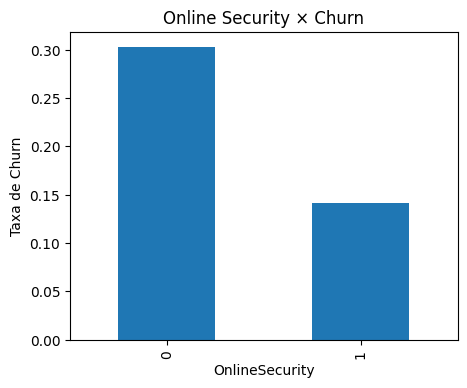

In [114]:
clientes.groupby('OnlineSecurity')['Churn'].mean().plot(
    kind='bar',
    figsize=(5,4),
    title='Online Security × Churn'
)
plt.ylabel('Taxa de Churn')
plt.show()

####<font color="8C00FF">TechSupport × Churn

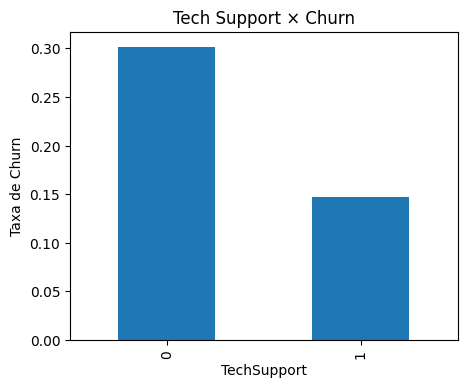

In [115]:
clientes.groupby('TechSupport')['Churn'].mean().plot(
    kind='bar',
    figsize=(5,4),
    title='Tech Support × Churn'
)
plt.ylabel('Taxa de Churn')
plt.show()

####<font color="8C00FF">Charges.Monthly × Churn

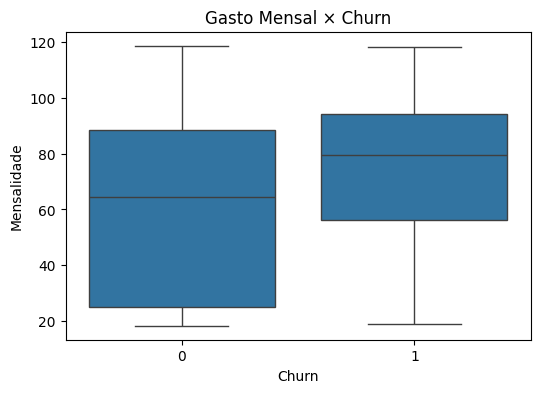

In [116]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='Charges.Monthly', data=clientes)
plt.title('Gasto Mensal × Churn')
plt.xlabel('Churn')
plt.ylabel('Mensalidade')
plt.show()

####<font color="8C00FF">SeniorCitizen × Churn

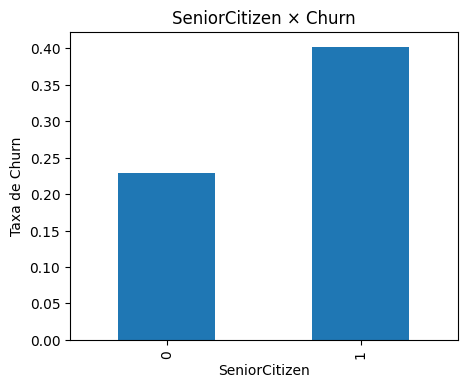

In [117]:
clientes.groupby('SeniorCitizen')['Churn'].mean().plot(
    kind='bar',
    figsize=(5,4),
    title='SeniorCitizen × Churn'
)
plt.ylabel('Taxa de Churn')
plt.show()

###<font color="8C00FF">**5.3. Interpretação da correlação:**</font>


<font color="450693">A análise das relações específicas com a evasão indica que clientes
com **contratos mensais**, **pagamento via electronic check** e ausência
de suporte técnico **negrito** e **segurança online** apresentam maiores
taxas de evasão, enquanto maior tempo de contrato e a presença desses
serviços exercem efeito protetor contra o churn.

---

####<font color = "9E1C60"> Variáveis para usar no treinamento do modelo:
* <font color = "9E1C60">Tenure
* <font color = "9E1C60">Contract_Month-to-month
* <font color = "9E1C60">Payment_Eletronic check
* <font color = "9E1C60">OnlineSecurity
* <font color = "9E1C60">TechSupport
* <font color = "9E1C60">Charges_Monthly
* <font color = "9E1C60">SeniorCitzen



In [118]:
print(
    "A análise das relações específicas com a evasão indica que clientes\n"
    "com contratos mensais, pagamento via electronic check e ausência\n"
    "de serviços como suporte técnico e segurança online apresentam maiores\n"
    "taxas de evasão, enquanto maior tempo de contrato e a presença desses\n"
    "serviços exercem efeito protetor contra o churn."
)

A análise das relações específicas com a evasão indica que clientes
com contratos mensais, pagamento via electronic check e ausência
de serviços como suporte técnico e segurança online apresentam maiores
taxas de evasão, enquanto maior tempo de contrato e a presença desses
serviços exercem efeito protetor contra o churn.


# <font color="9E1C60">**6. Divisão de treino e teste**</font>

---
<font color="8C00FF">Divisão comum é 70% para treino e 30% para teste</font>

<font color="450693">
<font color="8C00FF">
<font color="9E1C60">
<font color="FF9D00">

In [119]:
X = clientes.drop('Churn', axis=1)
y = clientes['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# <font color="9E1C60">**7. Criação dos dois modelos**</font>

---
<font color="8C00FF">**Justificativa da Regressão Logística:**</font>
<font color="8C00FF"> Indicação das variaveis que provavelmente vão aumentar o Churn e quais podem diminuir.Teve uma boa acurácia e F1,sendo facilmente interpretavel para análises explicativas.

---
<font color="8C00FF">**Justificativa da RandomForest:**</font>
<font color="8C00FF"> foi usado por ser um modelo mais capaz de analisar padrões mais complexos nos dados, como as interações entre as variáveis, que podem ocorrer com o comportamento variavel dos clientes.

<font color="450693"><font color="8C00FF"><font color="9E1C60"><font color="FF9D00">


#### <font color="9E1C60">**7.1. Modelo Regressão Logística**</font>
<font color="450693">
<font color="8C00FF">
<font color="9E1C60">
<font color="FF9D00">

In [120]:
modelo_Regressao = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

modelo_Regressao.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000))])

#### <font color="9E1C60">**7.2. Modelo RandomForest**</font>
<font color="450693">
<font color="8C00FF">
<font color="9E1C60">
<font color="FF9D00">

In [121]:
modelo_RandomForest = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

modelo_RandomForest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

# <font color="9E1C60">**8. Avaliação dos modelos**</font>
---


<font color="450693">
<font color="8C00FF">
<font color="9E1C60">
<font color="FF9D00">

In [122]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

### <font color="9E1C60">**8.1. Gerar previsões**</font>

<font color="450693">
<font color="8C00FF">
<font color="9E1C60">
<font color="FF9D00">

In [123]:
# Previsões
y_pred_log = modelo_Regressao.predict(X_test)
y_pred_rf = modelo_RandomForest.predict(X_test)

### <font color="9E1C60">**8.2. Avaliação Modelo Regressão Logística**</font>

<font color="450693">
<font color="8C00FF">
<font color="9E1C60">
<font color="FF9D00">

In [124]:
acc_log = accuracy_score(y_test, y_pred_log) * 100
prec_log = precision_score(y_test, y_pred_log) * 100
rec_log = recall_score(y_test, y_pred_log) * 100
f1_log = f1_score(y_test, y_pred_log) * 100
cm_log = confusion_matrix(y_test, y_pred_log)

print('Regressão Logística')
print("=" * 70)
print(f'Acurácia : {acc_log:.2f}%')
print(f'Precisão : {prec_log:.2f}%, acusa Churn em excesso')
print(f'Recall   : {rec_log:.2f}%, dos churns reais foram corretamente identificados')
print(f'F1-score : {f1_log:.2f}%')
print("=" * 70)

Regressão Logística
Acurácia : 80.10%
Precisão : 63.54%, acusa Churn em excesso
Recall   : 53.12%, dos churns reais foram corretamente identificados
F1-score : 57.86%


### <font color="9E1C60">**8.3. Matriz de Confusão Modelo Regressão Logistica**</font>

<font color="450693">
<font color="8C00FF">
<font color="9E1C60">
<font color="FF9D00">

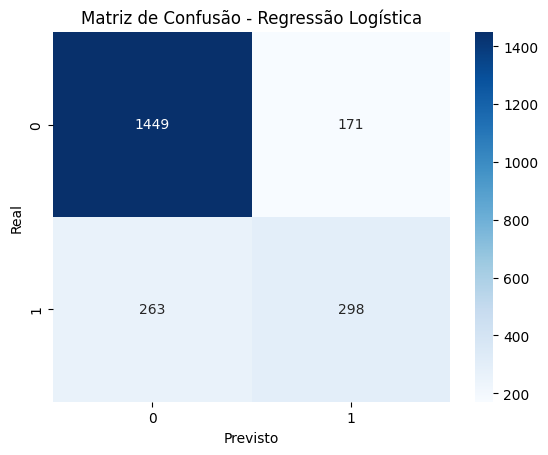

In [125]:
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Regressão Logística')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()


### <font color="9E1C60">**8.4. Avaliação Modelo RandomForest**</font>

<font color="450693">
<font color="8C00FF">
<font color="9E1C60">
<font color="FF9D00">

In [126]:
acc_rf = accuracy_score(y_test, y_pred_rf) * 100
prec_rf = precision_score(y_test, y_pred_rf) * 100
rec_rf = recall_score(y_test, y_pred_rf) * 100
f1_rf = f1_score(y_test, y_pred_rf) * 100
cm_rf = confusion_matrix(y_test, y_pred_rf)

print('📌 Random Forest')
print("=" * 70)
print(f'Acurácia : {acc_rf:.2f}%')
print(f'Precisão : {prec_rf:.2f}%')
print(f'Recall   : {rec_rf:.2f}%')
print(f'F1-score : {f1_rf:.2f}%')
print("=" * 70)

📌 Random Forest
Acurácia : 78.95%
Precisão : 61.49%
Recall   : 48.66%
F1-score : 54.33%


### <font color="9E1C60">**8.5.Matriz de Confusão Modelo RandomForest**</font>

<font color="450693">
<font color="8C00FF">
<font color="9E1C60">
<font color="FF9D00">

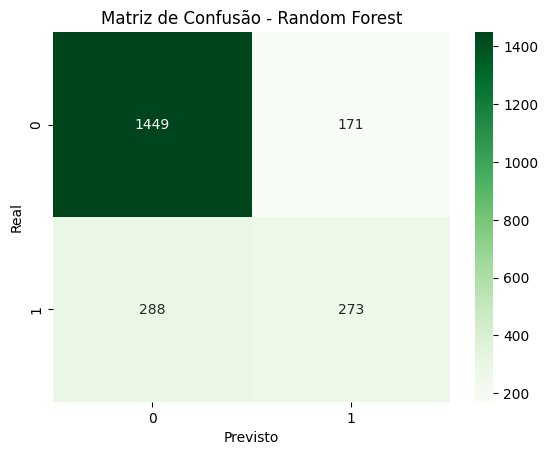

In [127]:
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

# <font color="9E1C60">**9. Comparando Modelos**</font>

---



<font color="450693">
<font color="8C00FF">
<font color="9E1C60">
<font color="FF9D00">

In [128]:
import pandas as pd

avaliacao = pd.DataFrame({
    'Modelo': ['Regressão Logística', 'Random Forest'],
    'Acurácia': [acc_log, acc_rf],
    'Precisão': [prec_log, prec_rf],
    'Recall': [rec_log, rec_rf],
    'F1-score': [f1_log, f1_rf]
})

avaliacao_corrigida = avaliacao.copy()

metricas = ['Acurácia', 'Precisão', 'Recall', 'F1-score']

# Dividindo por 100 (corrige a dupla conversão)
avaliacao_corrigida[metricas] = avaliacao_corrigida[metricas]

# Garantindo 2 casas decimais
avaliacao_corrigida[metricas] = avaliacao_corrigida[metricas].round(2)

avaliacao_corrigida



,Modelo,Acurácia,Precisão,Recall,F1-score
0,Regressão Logística,80.10,63.54,53.12,57.86
1,Random Forest,78.95,61.49,48.66,54.33


###<font color ="9E1C60">**9.1. Interpretação dos modelos**</font>

<font color="450693">
<font color="8C00FF">
<font color="9E1C60">
<font color="FF9D00">

<font color = "9E1C60">Em comparação, **Regressão Logística** teve o melhor desempenho pois:

<font color = "9E1C60">Maior Recall → identificou mais clientes que realmente churnaram

<font color = "9E1C60">Maior F1-score → melhor equilíbrio entre erro e acertoaaa

<font color = "9E1C60">Maior Precisão → menos falsos positivos

---

<font color = "9E1C60">Diferença de acurácia não é relevante para Churn, Recall e F1 são mais importantes que Acurácia.

---

###<font color="9E1C60">**9.2.Verificando overfitting e underfitting**</font>

<font color="8C00FF">
<font color= "9E1C60">
<font color="FF9D00">
<font color="450693">

<font color="9E1C60"> Previsões no treino e teste</font>

In [129]:
# Previsões - Regressão Logística
y_train_pred_log = modelo_Regressao.predict(X_train)
y_test_pred_log  = modelo_Regressao.predict(X_test)

# Previsões - Random Forest
y_train_pred_rf = modelo_RandomForest.predict(X_train)
y_test_pred_rf  = modelo_RandomForest.predict(X_test)

<font color="9E1C60">Funcao para calcular métrica

In [130]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calcular_metricas(y_real, y_pred):
    return {
        'Acurácia': accuracy_score(y_real, y_pred),
        'Precisão': precision_score(y_real, y_pred),
        'Recall': recall_score(y_real, y_pred),
        'F1-score': f1_score(y_real, y_pred)
    }


<font color="9E1C60">Treino e Teste - Modelo Regressão Logística

In [131]:
metricas_Regressao_treino = calcular_metricas(y_train, y_train_pred_log)
metricas_Regressao_teste  = calcular_metricas(y_test, y_test_pred_log)

<font color="9E1C60">Treino e Teste - Modelo RandomForest

In [132]:
metricas_RandomForest_treino = calcular_metricas(y_train, y_train_pred_rf)
metricas_RandomForest_teste  = calcular_metricas(y_test, y_test_pred_rf)


<font color="9E1C60"> Comparando

In [133]:
comparacao = pd.DataFrame([
    {'Modelo': 'Regressão Logística', 'Conjunto': 'Treino', **metricas_Regressao_treino},
    {'Modelo': 'Regressão Logística', 'Conjunto': 'Teste',  **metricas_Regressao_teste},
    {'Modelo': 'Random Forest',       'Conjunto': 'Treino', **metricas_RandomForest_treino},
    {'Modelo': 'Random Forest',       'Conjunto': 'Teste',  **metricas_RandomForest_teste},
])

# Converter para percentual
metricas = ['Acurácia', 'Precisão', 'Recall', 'F1-score']
comparacao[metricas] = (comparacao[metricas] * 100).round(2)

comparacao


,Modelo,Conjunto,Acurácia,Precisão,Recall,F1-score
0,Regressão Logística,Treino,80.73,65.65,52.60,58.40
1,Regressão Logística,Teste,80.10,63.54,53.12,57.86
2,Random Forest,Treino,99.21,98.55,98.39,98.47
3,Random Forest,Teste,78.95,61.49,48.66,54.33


### <font color= "9E1C60">**9.3. Conclusão**</font>

<font color= "9E1C60">**Regressão Logística:**</font>

* Diferenças mínimas entre treino e teste

* Recall praticamente idêntico

<font color= "9E1C60">**Conclusão:**</font>
* Não há overfitting
* Não há underfitting
* **Modelo bem ajustado e estável**

---

<font color= "9E1C60">**RandomForest:**<font>
* Desempenho quase perfeito no Treino
* Queda brusca no Teste (Recall com maior queda)

<font color= "9E1C60">**Conclusão:**</font>
* Overfiting(modelo decorou dados de treino)

#<font color="FF9D00">**10. Análise da importancia das Variáveis**</font>

###<font color="FF9D00">**10.1. Análise dos Coeficientes - Modelo Regressao Logistica**</font>

In [134]:
coeficientes = modelo_Regressao.named_steps['logreg'].coef_[0]

# Nomes das variáveis usadas no treino
variaveis_modelo = X_train.columns

coef_Regressao = pd.DataFrame({
    'Variavel': variaveis_modelo,
    'Coeficiente': coeficientes
})

# Impacto absoluto para ranking
coef_Regressao['Impacto_Abs'] = coef_Regressao['Coeficiente'].abs()

# Ordenar por impacto
coef_Regressao = coef_Regressao.sort_values('Impacto_Abs', ascending=False)

coef_Regressao.head(10)


,Variavel,Coeficiente,Impacto_Abs
4,tenure,-1.385262,1.385262
13,Charges.Monthly,-0.811478,0.811478
14,Charges.Total,0.667832,0.667832
26,Internet_No,-0.647409,0.647409
25,Internet_Fiber optic,0.610616,0.610616
20,Contract_Two year,-0.295773,0.295773
18,Contract_Month-to-month,0.285670,0.285670
11,StreamingMovies,0.239113,0.239113
10,StreamingTV,0.216137,0.216137
12,PaperlessBilling,0.190115,0.190115


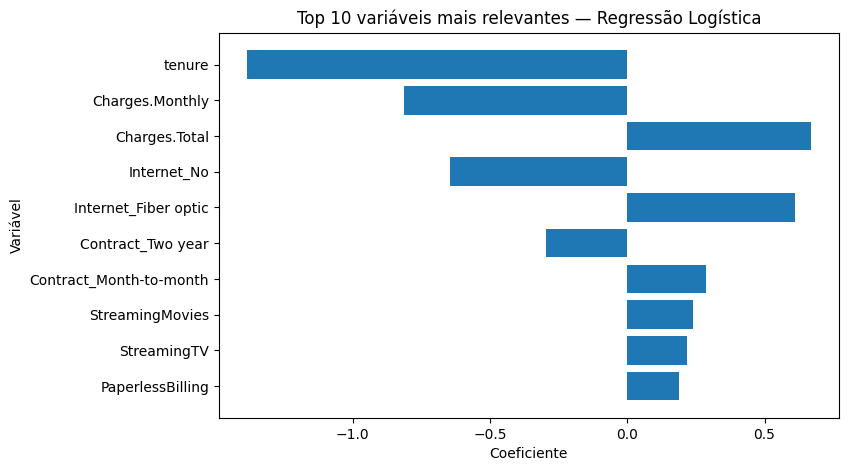

In [135]:
top_Regressao = coef_Regressao.head(10)

plt.figure(figsize=(8,5))
plt.barh(top_Regressao['Variavel'], top_Regressao['Coeficiente'])
plt.title('Top 10 variáveis mais relevantes — Regressão Logística')
plt.xlabel('Coeficiente')
plt.ylabel('Variável')
plt.gca().invert_yaxis()
plt.show()

#**<font color="FF9D00">11. Criando um simulador interativo**</font>

---



In [187]:
# Importando bibliotecas
from ipywidgets import widgets, HBox, VBox
from IPython.display import display, clear_output

titulo = widgets.HTML( value="<h2 style='text-align:left;'>Previsão de Risco de Churn para novos clientes:</h2>")

# Criando os controles do simulador
gender = widgets.Dropdown(options=['Male', 'Female'], description="Gênero:")
senior = widgets.Dropdown(options=['Yes', 'No'], description="Sênior:")
partner = widgets.Dropdown(options=['Yes', 'No'], description="Parceiro:")
dependents = widgets.Dropdown(options=['Yes', 'No'], description="Dependentes:")
internet = widgets.Dropdown(options=['DSL', 'Fiber optic', 'No'], description="Serviço de Internet:")
onlineSecurity = widgets.Dropdown(options=['Yes', 'No', 'No internet service'], description="Segurança Online:")
online_backup = widgets.Dropdown(options=['Yes', 'No', 'No internet service'], description="Backup Online:")
techSupport = widgets.Dropdown(options=['Yes', 'No', 'No internet service'], description="Suporte Técnico:")
contract = widgets.Dropdown(options=['Month-to-month', 'One year', 'Two year'], description="Tipo de Contrato:")
payment = widgets.Dropdown(options=['Electronic check','Mailed check','Bank transfer (automatic)','Credit card (automatic)'],description="Método de Pagamento:")
tenure = widgets.IntText(value=1, description='Tenure:')
charges_monthly = widgets.FloatText(value=70.0, description='Pagamento mensal (R$):')

#Criando botão
botao = widgets.Button( description='Prever Churn', button_style='danger')
botao = widgets.Button(description='Prever Churn',layout=widgets.Layout(width='200px'))
botao.style.button_color = '#FF9D00'
botao.style.font_weight = 'bold'


# Função de simulação
def prever_churn(b):
    clear_output(wait=True)

    # 1. Create a raw DataFrame mirroring the original input structure for ONE customer
    raw_cliente_data = {
        'gender': [gender.value],
        'SeniorCitizen': [senior.value],
        'Partner': [partner.value],
        'Dependents': [dependents.value],
        'tenure': [tenure.value],
        'PhoneService': ['Yes'],
        'MultipleLines': ['No'], # Hardcoded based on initial client_novo structure
        'InternetService': [internet.value],
        'OnlineSecurity': [onlineSecurity.value],
        'OnlineBackup': [online_backup.value],
        'DeviceProtection': ['No'], # Hardcoded based on initial client_novo structure
        'TechSupport': [techSupport.value],
        'StreamingTV': ['Yes'], # Hardcoded based on initial client_novo structure
        'StreamingMovies': ['Yes'], # Hardcoded based on initial client_novo structure
        'Contract': [contract.value],
        'PaperlessBilling': ['Yes'], # Hardcoded based on initial client_novo structure
        'PaymentMethod': [payment.value],
        'Charges.Monthly': [charges_monthly.value],
        'Charges.Total': [tenure.value * charges_monthly.value] # Calculated
    }
    cliente_novo_raw = pd.DataFrame(raw_cliente_data)

    # Apply the same preprocessing steps as the training data

    # Convert numeric columns
    cliente_novo_raw['tenure'] = pd.to_numeric(cliente_novo_raw['tenure'], errors='coerce')
    cliente_novo_raw['Charges.Monthly'] = pd.to_numeric(cliente_novo_raw['Charges.Monthly'], errors='coerce')
    cliente_novo_raw['Charges.Total'] = pd.to_numeric(cliente_novo_raw['Charges.Total'], errors='coerce').fillna(0)

    temp_df = cliente_novo_raw.copy()

    # Ensure string types for categorical columns before get_dummies
    for col in ['PaymentMethod', 'Contract', 'MultipleLines', 'InternetService']:
        temp_df[col] = temp_df[col].astype(str)

    # One-Hot Encoding for multi-categorical variables - matching original notebook's drop_first settings
    temp_df = pd.get_dummies(temp_df, columns=['PaymentMethod'], prefix='Payment', drop_first=True)
    temp_df = pd.get_dummies(temp_df, columns=['Contract'], prefix='Contract', drop_first=False)
    temp_df = pd.get_dummies(temp_df, columns=['MultipleLines'], prefix='Multilines', drop_first=False)
    temp_df = pd.get_dummies(temp_df, columns=['InternetService'], prefix='Internet', drop_first=False)

    # Rename 'gender' and map it to numerical values
    temp_df.rename(columns={'gender': 'Sexo_masculino'}, inplace=True)
    temp_df['Sexo_masculino'] = temp_df['Sexo_masculino'].map({'Male': 1, 'Female': 0})

    # Map binary columns (Yes/No)
    colunas_yes_no_mapping = [
        'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling'
    ]
    mapa_yes_no_simulador = {'Yes': 1, 'No': 0}
    for col in colunas_yes_no_mapping:
        temp_df[col] = temp_df[col].map(mapa_yes_no_simulador)

    # Map service columns (Yes/No/No internet service)
    colunas_servicos_mapping = [
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
    ]
    mapa_servicos_simulador = {'Yes': 1, 'No': 0, 'No internet service': 0}
    for col in colunas_servicos_mapping:
        temp_df[col] = temp_df[col].map(mapa_servicos_simulador)

    # Convert boolean columns to int
    colunas_bool_temp = temp_df.select_dtypes(include='bool').columns
    temp_df[colunas_bool_temp] = temp_df[colunas_bool_temp].astype(int)

    # Align columns with X_train
    expected_columns = X_train.columns.tolist()

    # Add missing columns (from X_train) to temp_df with 0
    for col in expected_columns:
        if col not in temp_df.columns:
            temp_df[col] = 0

    # Drop extra columns (in temp_df but not in X_train)
    for col in temp_df.columns:
        if col not in expected_columns:
            temp_df = temp_df.drop(columns=[col])

    # Reorder columns
    cliente_novo_final = temp_df[expected_columns]

    prob = modelo_RandomForest.predict_proba(cliente_novo_final)[0, 1]

    # Reexibir formulário
    display(simulador)

    print(f'🔮 Probabilidade de churn: {prob:.2%}')
    print(f'- Tenure: {tenure.value} meses')
    print(f'- Contract: {contract.value}')

    if(prob > 0.7 and tenure.value < 6 and contract.value == 'Month-to-month'):
        print('🚨 Alto risco de Churn — contato imediato')
    elif prob > 0.4:
        print('⚠️ Risco moderado de Churn — acompanhamento')
    else:
        print('✅ Baixo risco de Churn')

# Atribuindo a função "simulador" ao evento click do botão
botao.on_click(prever_churn)

# Posicionando os controles
left_widgets = VBox([gender, partner, internet, online_backup, contract, tenure])
right_widgets = VBox([senior, dependents, onlineSecurity, techSupport, payment, charges_monthly])

inputs = HBox([left_widgets, right_widgets])
simulador = VBox([titulo, inputs, botao])

display(simulador)


🔮 Probabilidade de churn: 26.00%
- Tenure: 2 meses
- Contract: Two year
✅ Baixo risco de Churn


#<font color="FF9D00">**12. Exportando os visuais para relatório**</font>

---



In [152]:
#<font color="450693"><font color="8C00FF"><font color="9E1C60"><font color="FF9D00">

import matplotlib.pyplot as plt

def prop_clientes():
    counts = clientes['Churn'].value_counts().sort_index()
    labels = ['Clientes Ativos', 'Clientes com Churn']
    colors = ['#FFF7CD', '#FF9D00']

    def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct * total / 100.0))
            return f'{val}\n({pct:.1f}%)'
        return my_format

    fig, ax = plt.subplots(figsize=(7, 7))

    ax.pie(
        counts,
        labels=labels,
        colors=colors,
        autopct=autopct_format(counts),
        startangle=90,
        pctdistance=0.65,
        labeldistance=1.05,
        textprops={'fontsize': 10}
    )

    ax.set_title(
        'Clientes Ativos x Churn',
        fontsize=12,
        weight='bold',
        pad=20
    )

    ax.axis('equal')

    return fig


In [165]:
import matplotlib.pyplot as plt

def perfil_clientes():
    top_Regressao = coef_Regressao.head(10)

    # Define cores conforme o sinal do coeficiente
    cores = [
        '#FF9D00' if coef > 0 else '#FFF7CD'
        for coef in top_Regressao['Coeficiente']
    ]

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.barh(
        top_Regressao['Variavel'],
        top_Regressao['Coeficiente'],
        color=cores
    )

    ax.set_title(
        'Top 10 variáveis mais relevantes — Regressão Logística',
        fontsize=14,
        weight='bold',
        pad=15
    )

    ax.set_xlabel('Coeficiente', fontsize=11)
    ax.set_ylabel('Variável', fontsize=11)

    ax.invert_yaxis()
    ax.grid(axis='x', linestyle='--', alpha=0.4)

    return fig

In [177]:
def comparacao_modelos():
    df = comparacao.copy()

    metricas = ['Acurácia', 'Precisão', 'Recall', 'F1-score']
    x = np.arange(len(metricas))
    largura = 0.35

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    modelos = ['Regressão Logística', 'Random Forest']

    cores = {
        'Treino': '#FFF7CD',
        'Teste': '#FF9D00'
    }

    for ax, modelo in zip(axes, modelos):
        dados_modelo = df[df['Modelo'] == modelo]

        treino = dados_modelo[dados_modelo['Conjunto'] == 'Treino'][metricas].values[0]
        teste  = dados_modelo[dados_modelo['Conjunto'] == 'Teste'][metricas].values[0]

        ax.bar(
            x - largura/2,
            treino,
            largura,
            label='Treino',
            color=cores['Treino']
        )

        ax.bar(
            x + largura/2,
            teste,
            largura,
            label='Teste',
            color=cores['Teste']
        )

        ax.set_title(modelo, fontsize=14, weight='bold', pad=12)
        ax.set_xticks(x)
        ax.set_xticklabels(metricas, fontsize=11)
        ax.set_ylim(0, 100)
        ax.grid(axis='y', linestyle='--', alpha=0.4)

    axes[0].set_ylabel('Percentual (%)', fontsize=11)
    axes[1].legend(title='Conjunto')

    fig.suptitle(
        'Comparação de Desempenho — Treino vs Teste',
        fontsize=16,
        weight='bold',
        y=1.05
    )

    fig.tight_layout()

    return fig

In [179]:
def salvar_grafico(grafico, nome):
    imagem = grafico()
    imagem.savefig(f'{nome}.png', bbox_inches='tight')
    plt.close(imagem)

salvar_grafico(prop_clientes, 'grafico_prop_clientes')
salvar_grafico(variaveis_evasivas, 'grafico_variaveis_evasivas')
salvar_grafico(comparacao_modelos, 'grafico_modelos')
#salvar_grafico(servicos_adicionais, 'grafico_serv_adicionais')
#salvar_grafico(internet, 'grafico_internet')
#salvar_grafico(contrato, 'grafico_contrato')
#salvar_grafico(mensalidade, 'grafico_mensalidade')

#<font color="FF9D00">**13. Salvando Pickle**</font>

---


In [137]:
import pickle

try:
  with open('modelo_Avaliacao_Churn.pkl', 'wb') as file:
    pickle.dump(modelo_Regressao, file)
  print('Modelo salvo com sucesso!!!')
except Exception as e:
  print('Ocorreu um erro ao salvar o modelo: ', str(e))

Modelo salvo com sucesso!!!


##<font color="8C00FF">**Carregando modelo depois:**</font>

```
with open('modelo_Avaliacao_churn.pkl', 'rb') as file:
    modelo_carregado = pickle.load(file)

modelo_carregado.predict_proba(cliente_novo)
```



#<font color="450693">**14. Relatório**

---
> <font color="450693">**Principais fatores de evasão:**

* Contract_Month-to-month
* Charges.Monthly elevada
* Payment_Eletronic check


---


> <font color="450693">**Principais fatores de retenção:**

* Tempo de relacionamento
* OnlineSecurity
* TechSupport


| Variável                     | Efeito no Churn | Interpretação de Negócio                                               | Ação Recomendada                                                  |
| ---------------------------- | --------------- | ---------------------------------------------------------------------- | ----------------------------------------------------------------- |
| **Contract_Month-to-month**  | **↑ Forte**     | Clientes sem contrato longo têm maior propensão à evasão               | Incentivar migração para planos anuais com desconto ou benefícios |
| **tenure**                   | **↓ Forte**     | Quanto maior o tempo de relacionamento, menor o risco de churn         | Focar ações de retenção nos primeiros meses (onboarding ativo)    |
| **Charges.Monthly**          | **↑ Moderado**  | Contas mensais mais altas aumentam insatisfação                        | Oferecer downgrade inteligente ou bundles mais baratos            |
| **PaperlessBilling**         | **↑ Leve**      | Clientes digitais tendem a comparar mais preços e trocar de fornecedor | Criar ofertas personalizadas via canais digitais                  |
| **Payment_Electronic check** | **↑ Moderado**  | Método de pagamento menos conveniente gera fricção                     | Incentivar débito automático ou cartão com benefícios             |
| **SeniorCitizen**            | **↑ Leve**      | Clientes idosos apresentam maior sensibilidade a preço e serviço       | Atendimento dedicado e comunicação simplificada                   |
| **OnlineSecurity**           | **↓ Moderado**  | Serviços de valor agregado aumentam retenção                           | Oferecer trial gratuito ou cross-sell para clientes de risco      |
| **TechSupport**              | **↓ Moderado**  | Suporte técnico reduz frustração e aumenta fidelização                 | Destacar suporte premium em campanhas de retenção                 |
| **Charges.Total**            | **↓ Forte**     | Clientes que já investiram mais tendem a permanecer                    | Priorizar retenção de clientes de alto valor acumulado            |


In [181]:
tabela_executiva = pd.DataFrame({
    'Variável': [
        'SeniorCitizen',
        'Contract_Month-to-month',
        'PaperlessBilling',
        'Payment_Electronic check',
        'tenure',
        'Charges.Monthly',
        'Charges.Total',
        'OnlineSecurity',
        'TechSupport'
    ],
    'Efeito no Churn': [
        'Aumenta a evasão',
        'Aumenta fortemente a evasão',
        'Aumenta a evasão',
        'Aumenta a evasão',
        'Reduz a evasão quando maior',
        'Aumenta a evasão',
        'Reduz a evasão',
        'Reduz fortemente a evasão',
        'Reduz fortemente a evasão'
    ],
    'Ação Recomendada': [
        'Criar ofertas específicas para Seniors',
        'Incentivar contratos mais longos',
        'Incentivar clientes sobre pagamentos digitais',
        'Incentivar meios de pagamento automáticos',
        'Programas de fidelização por tempo de contrato',
        'Revisar política de preços',
        'Oferecer descontos progressivos',
        'Oferecer OnlineSecurity como diferencial',
        'Oferecer TechSupport proativo'
    ]
})


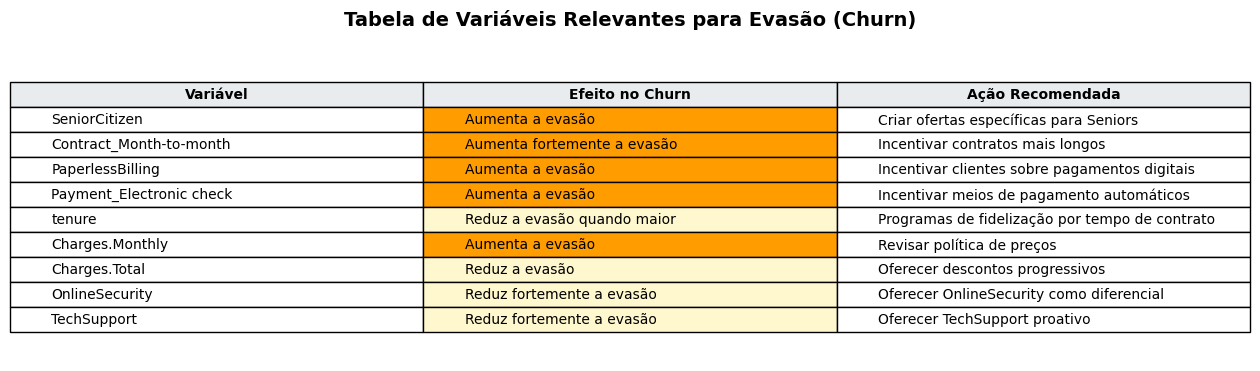

In [185]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.axis('off')

# Criar tabela visual
table = ax.table(
    cellText=tabela_executiva.values,
    colLabels=tabela_executiva.columns,
    cellLoc='left',
    loc='center'
)

# Ajustes visuais
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

for (row, col), cell in table.get_celld().items():

    # Ignora cabeçalho
    if row == 0:
        cell.set_facecolor('#E9ECEF')
        cell.set_text_props(weight='bold')
        continue

#<font color="450693">
#<font color="8C00FF">
#<font color="9E1C60">
#<font color="FF9D00">

    # Aplica cor baseado no texto
    if 'Aumenta' in cell.get_text().get_text():
        cell.set_facecolor('#FF9D00')  # amarelo
    elif 'Reduz' in cell.get_text().get_text():
        cell.set_facecolor('#FFF7CD')  # bege

# Título
plt.title(
    'Tabela de Variáveis Relevantes para Evasão (Churn)',
    fontsize=14,
    weight='bold',
    pad=20
)

# Exportar imagem
plt.savefig(
    'tabela_churn.png',
    dpi=300,
    bbox_inches='tight'
)

plt.show()
